# ARIMA Model on Stock Market Dataset

## Microsoft Opening Share Value Estimation

In this notebook, we shall predict the Microsoft opening share value using ARIMA Model. The dataset is taken from [Kaggle](https://www.kaggle.com/ryanforbes/msftstockdata/).

References for subsequent material can be found here:
 

1.   [ARIMA Model – Complete Guide to Time Series Forecasting in Python](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)
2.   [Stock Market Analysis Using ARIMA](https://towardsdatascience.com/stock-market-analysis-using-arima-8731ded2447a)



# Importing Libraries

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# import warnings
from google.colab import drive
from pandas import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller # for ADF Test
from statsmodels.tsa.arima_model import ARIMA # Our ARIMA Model here!
from sklearn.metrics import mean_squared_error

# Preprocessing

In [65]:
drive.mount('/content/gdrive')
dfull = pd.read_csv("/content/gdrive/My Drive/iPython Notebooks/daily_MSFT.csv").fillna(0)
dfull.head()

,timestamp,open,high,low,close,volume
0,2019-01-02,99.55,101.75,98.94,101.12,35329345
1,2018-12-31,101.29,102.40,100.44,101.57,33173765
2,2018-12-28,102.09,102.41,99.52,100.39,38169312
3,2018-12-27,99.30,101.19,96.40,101.18,49498509
4,2018-12-26,95.14,100.69,93.96,100.56,51634793


In [5]:
df = pd.read_csv("/content/gdrive/My Drive/iPython Notebooks/daily_MSFT.csv", usecols=["timestamp", "open"]).fillna(0)
df.timestamp = df.timestamp.values[::-1]
df.open = df.open.values[::-1]
df.head()

,timestamp,open
0,1998-01-02,129.63
1,1998-01-05,131.25
2,1998-01-06,129.75
3,1998-01-07,129.88
4,1998-01-08,128.63


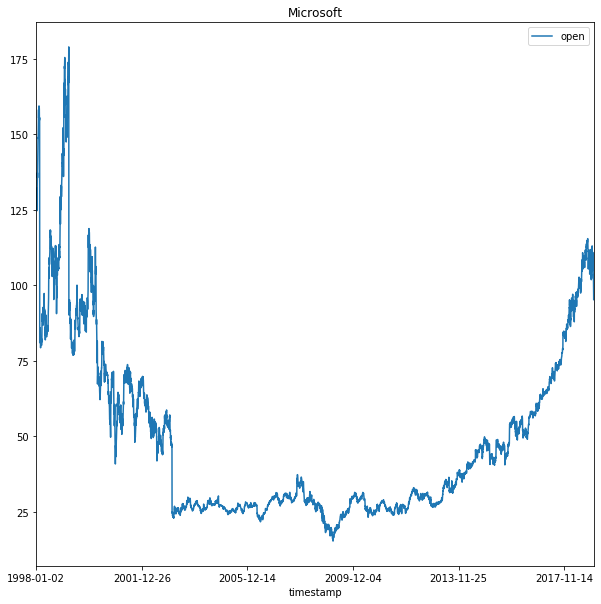

In [6]:
df.plot(x='timestamp', y='open', figsize=(10, 10))
plt.title("Microsoft")
plt.show()

In [7]:
final_index = len(df) - 1
print(final_index)
df['timestamp'][final_index] # latest data => recent most

5283


'2019-01-02'

# ARIMA for Time Series Prediction

## Step 1: Make the Time-Series Stationary

In [8]:
adf_result = adfuller(df.open.dropna())
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
for key, value in adf_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.364663
p-value: 0.012224
Critial Values:
   1%, -3.431595953076606
Critial Values:
   5%, -2.8620905823223675
Critial Values:
   10%, -2.567063074642111


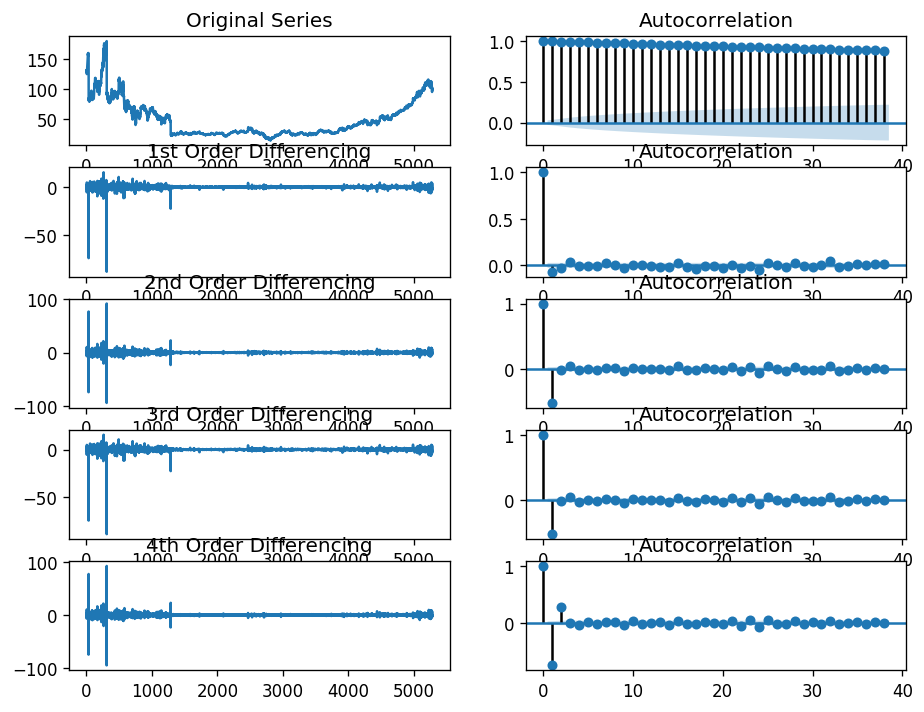

In [9]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(5, 2, sharex=False)
axes[0, 0].plot(df.open); axes[0, 0].set_title('Original Series')
plot_acf(df.open, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.open.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.open.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.open.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.open.diff().diff().dropna(), ax=axes[2, 1])

# 3rd Differencing
axes[3, 0].plot(df.open.diff()); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(df.open.diff().diff().dropna(), ax=axes[3, 1])

# 4th Differencing
axes[4, 0].plot(df.open.diff().diff()); axes[4, 0].set_title('4th Order Differencing')
plot_acf(df.open.diff().diff().diff().diff().dropna(), ax=axes[4, 1])

plt.show()

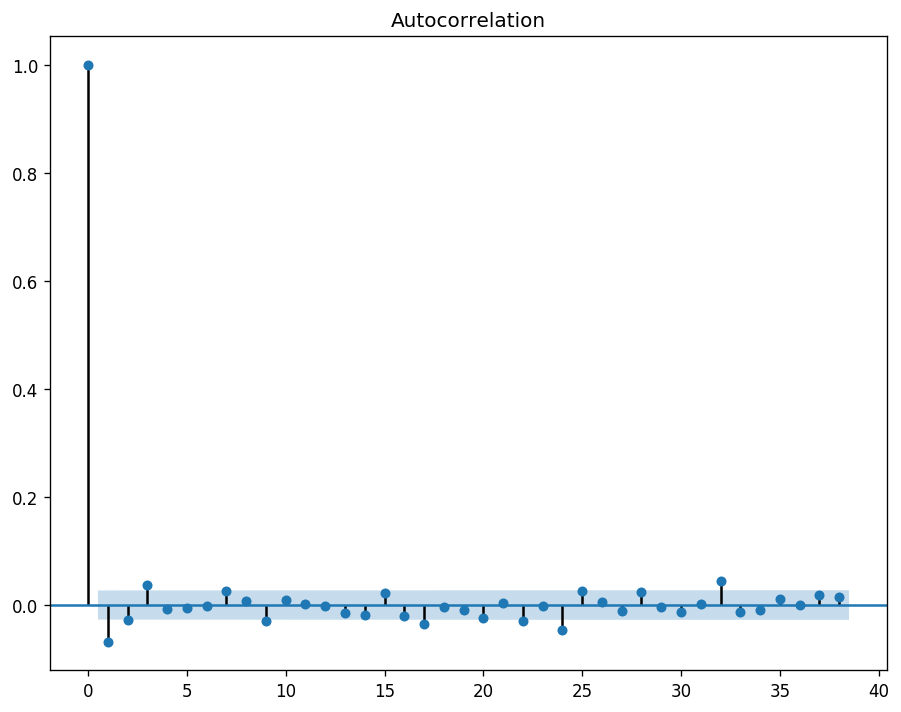

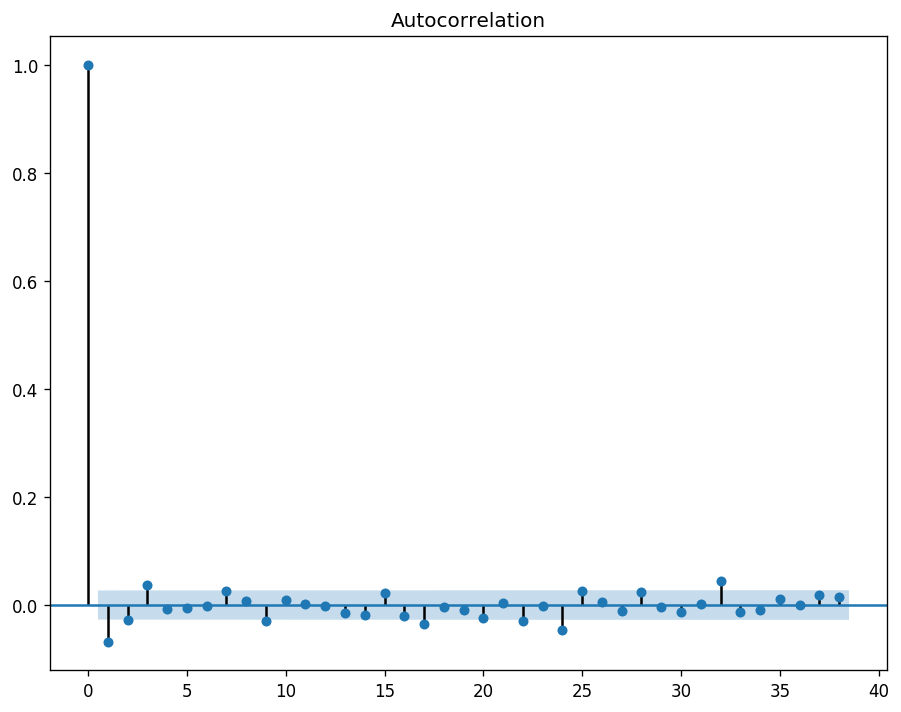

In [10]:
# 1st Differencing 
plot_acf(df.open.diff().dropna())

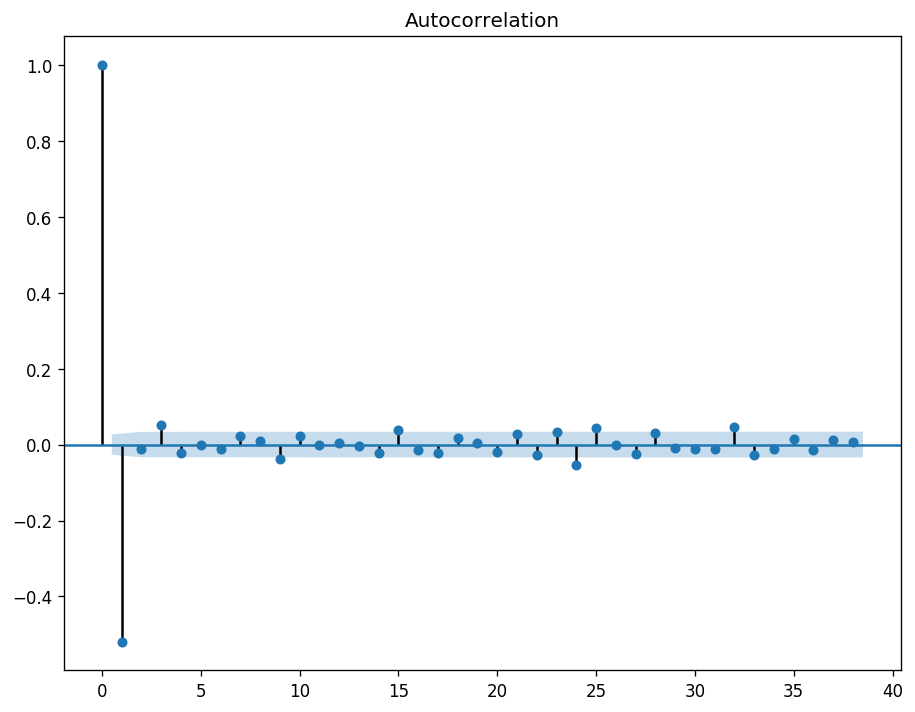

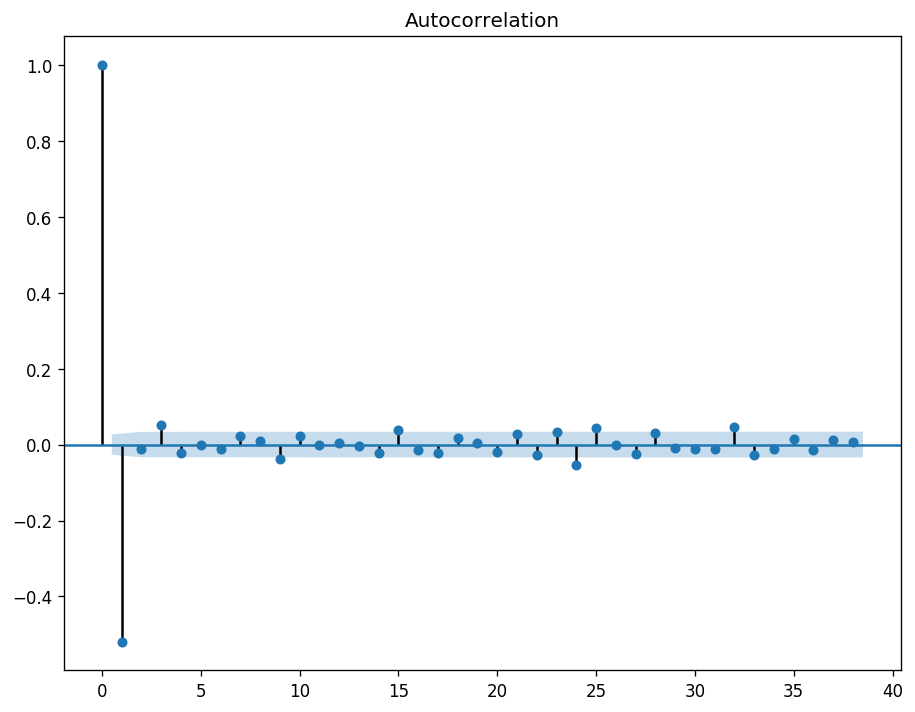

In [11]:
# 2nd Differencing 
plot_acf(df.open.diff().diff().dropna())

### We see that the plot for ACF on 2nd differencing reaches a negative value fairly quickly which indicates over-differencing. Therefore, we shall take the value of d as 1

In [0]:
# difference data
df_diff = df.open.diff()

In [13]:
adf_result_diff = adfuller(df_diff.dropna())
print('ADF Statistic: %f' % adf_result_diff[0])
print('p-value: %f' % adf_result_diff[1])
for key, value in adf_result_diff[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -42.279178
p-value: 0.000000
Critial Values:
   1%, -3.4315891064424116
Critial Values:
   5%, -2.862087557448897
Critial Values:
   10%, -2.567061464395374


### Thus, we see that the series is now stationary as it satisfies the ADF Test.

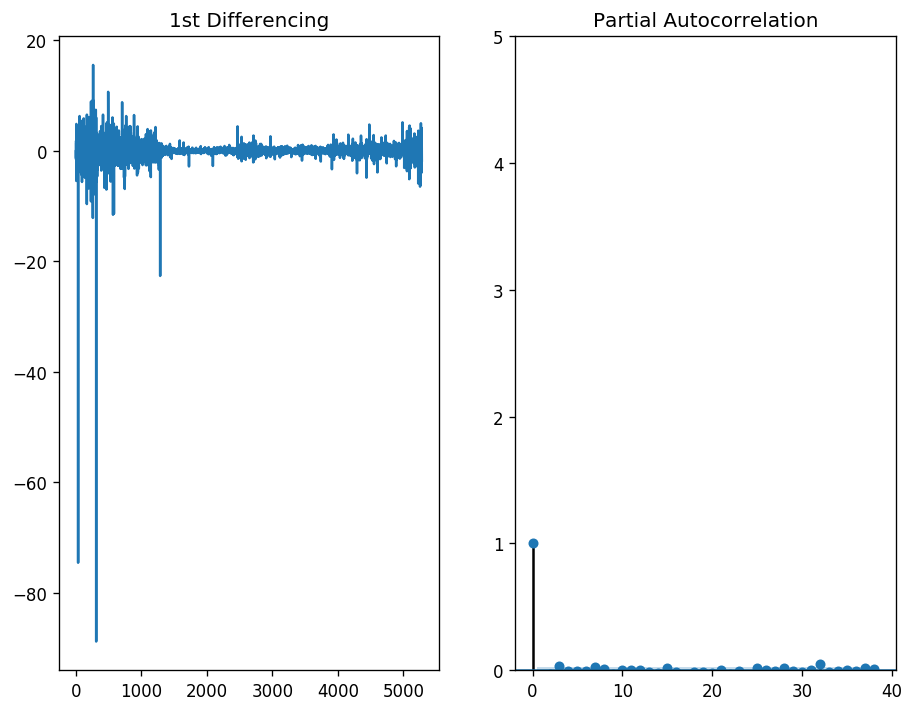

In [14]:
fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df_diff); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df_diff.dropna(), ax=axes[1])

plt.show()

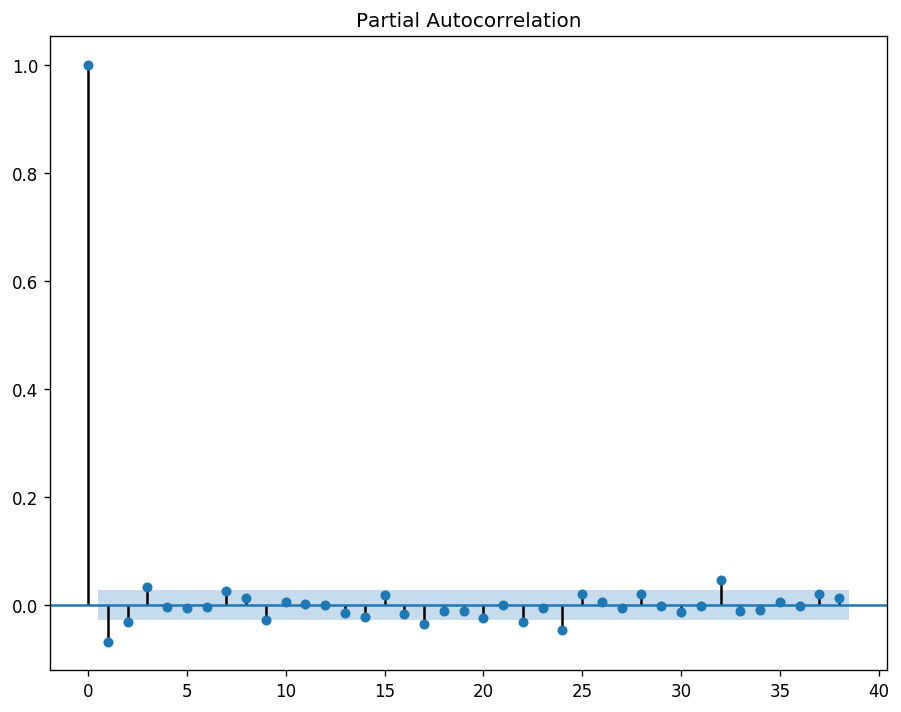

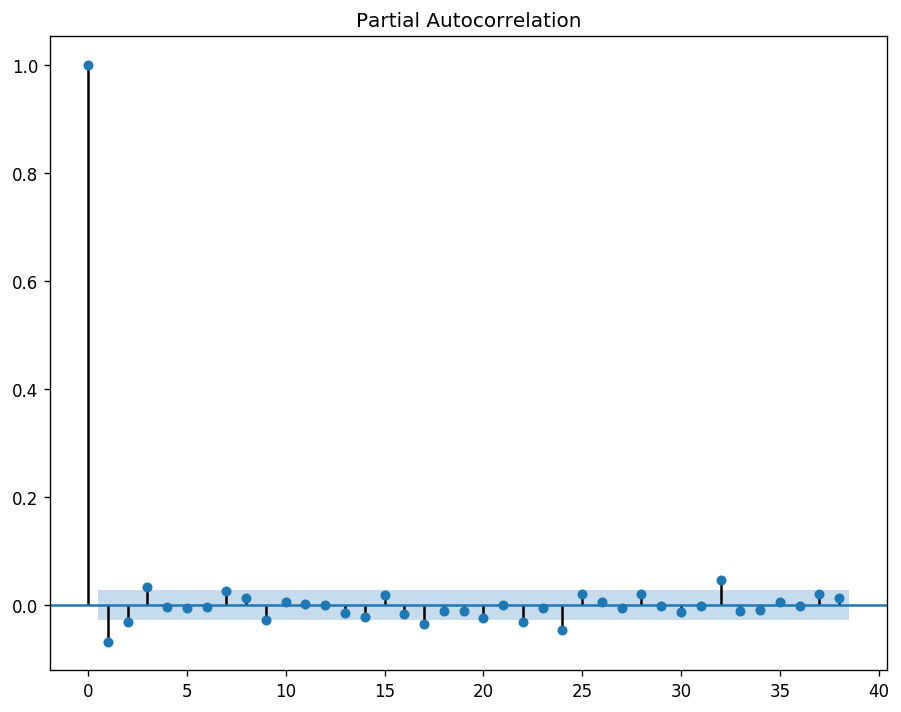

In [15]:
# Just plot PACF for clarity
plot_pacf(df_diff.dropna())

### We can see that only lag 1 has a significant value of PACF while higher lags barely cross the significance threshold (0.05). So, we choose p = 1

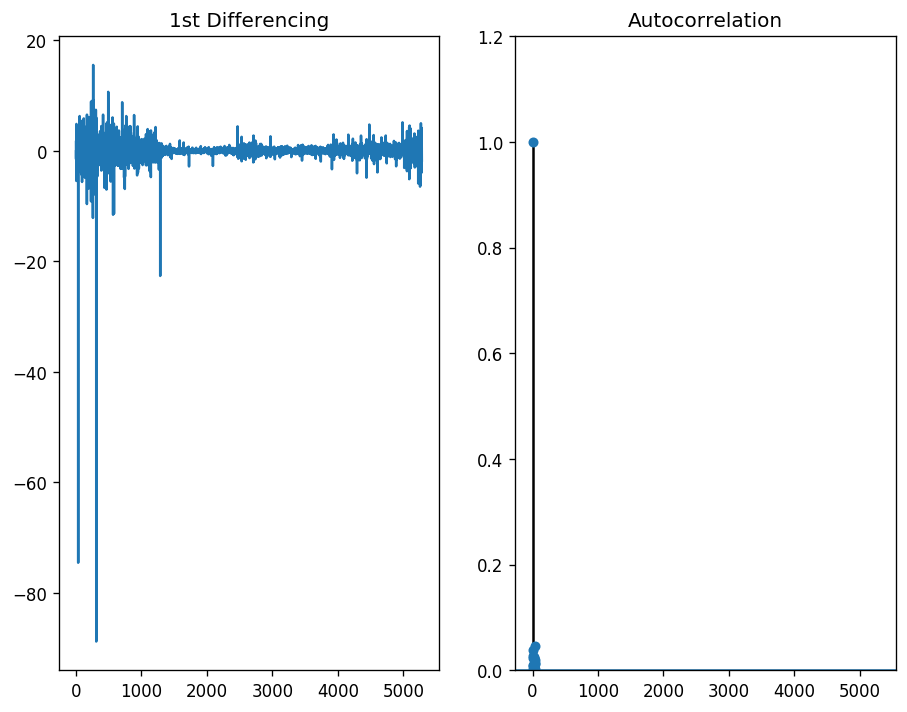

In [16]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df_diff); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df_diff.dropna(), ax=axes[1])

plt.show()

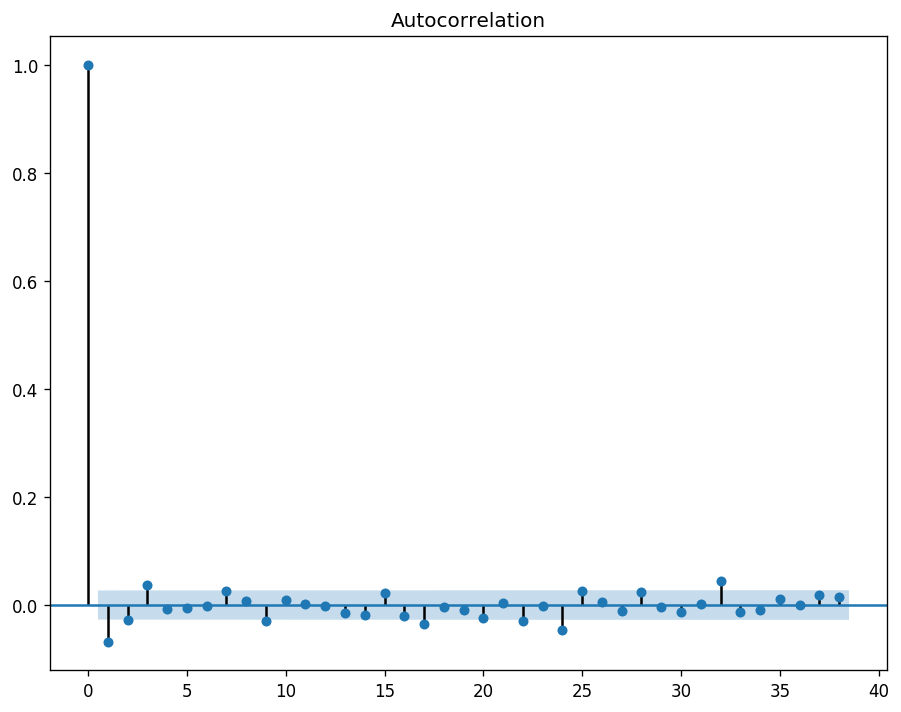

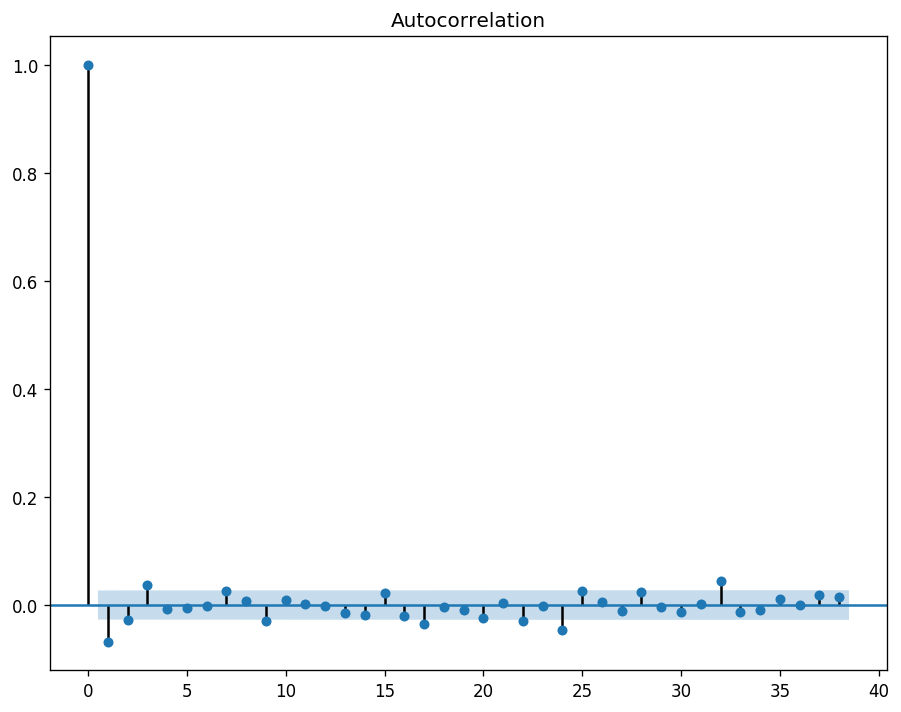

In [17]:
# Just Plot ACF for clarity
plot_acf(df_diff.dropna())

### Just like in the case of PACF, only lag 1 seems to be significant. Therefore, we choose q = 1

## Step 3: Fitting on the ARIMA Model

### First let's split the dataset into: training set (80%) and test set (20%)

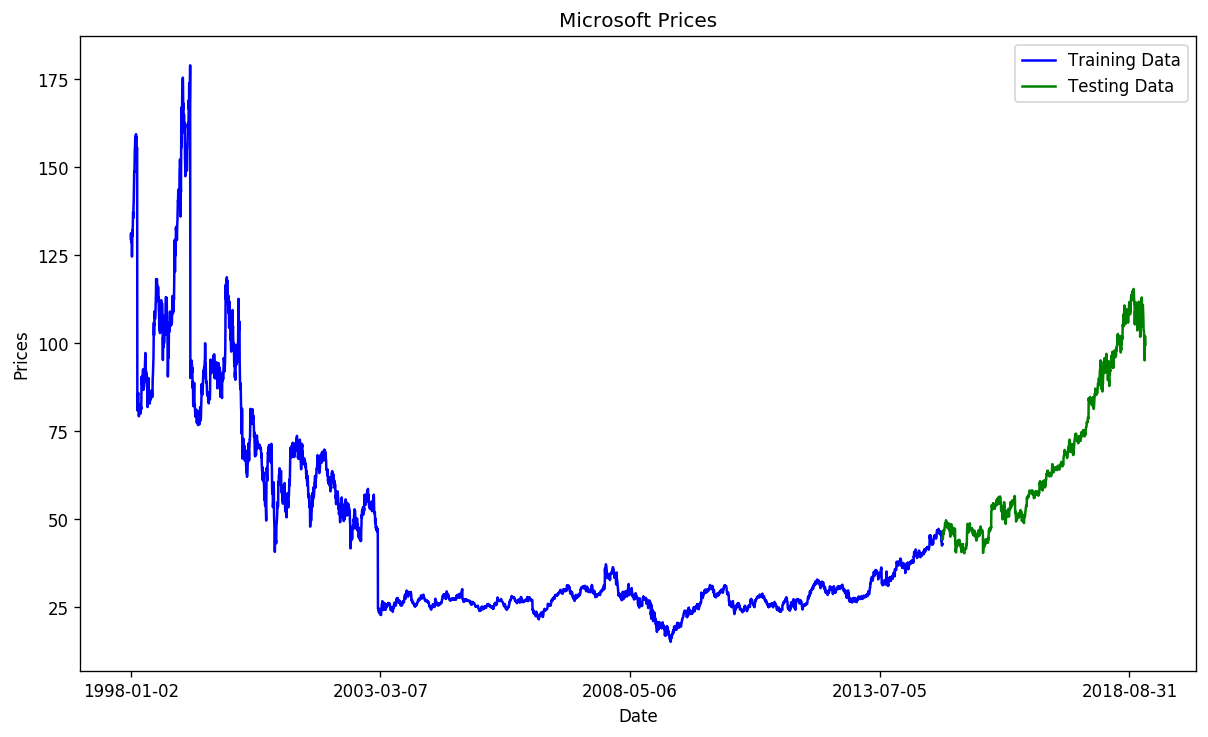

In [18]:
train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]
plt.figure(figsize=(12,7))
plt.title('Microsoft Prices')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.plot(train_data['open'], 'blue', label='Training Data')
plt.plot(test_data['open'], 'green', label='Testing Data')
plt.xticks(np.arange(0,final_index, 1300), df['timestamp'][0:final_index:1300])
plt.legend()

## Let's define the Error Metric: SMAPE (Symmetric Mean Absolute Percentage Error)

In [0]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

# New Section

## Training the Model and Error Check with MSE and SMAPE

##### Here, we train the model on the train_set and test it on the test_set
##### The model takes the ACTUAL value from the test_set and returns the predicted value for the next row and stores these predictions in the list 'predictions'. It is to be noted that SMAPE is a more reliable error metric in time series analysis than MSE.

In [23]:
train_ar = train_data['open'].values
test_ar = test_data['open'].values

history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    # training takes place here: 
    # p = 1, d = 0, q = 1 => fails to converge when run on google colab
    # p = 1, d = 1, q = 1 => succeeds in 771.731s with MSE = 1.135, SMAPE=33.785
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

<class 'list'>
Testing Mean Squared Error: 1.135
Symmetric mean absolute percentage error: 33.785


In [32]:
# let's see what kind of model we achieved
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 5282
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -11323.493
Method:                       css-mle   S.D. of innovations              2.064
Date:                Tue, 25 Feb 2020   AIC                          22654.986
Time:                        15:16:23   BIC                          22681.275
Sample:                             1   HQIC                         22664.174
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0054      0.026     -0.207      0.836      -0.056       0.046
ar.L1.D.y      0.1535      0.137      1.122      0.262      -0.115       0.422
ma.L1.D.y     -0.2240      0.135     -1.664      0.0

### Error Check Through Residuals

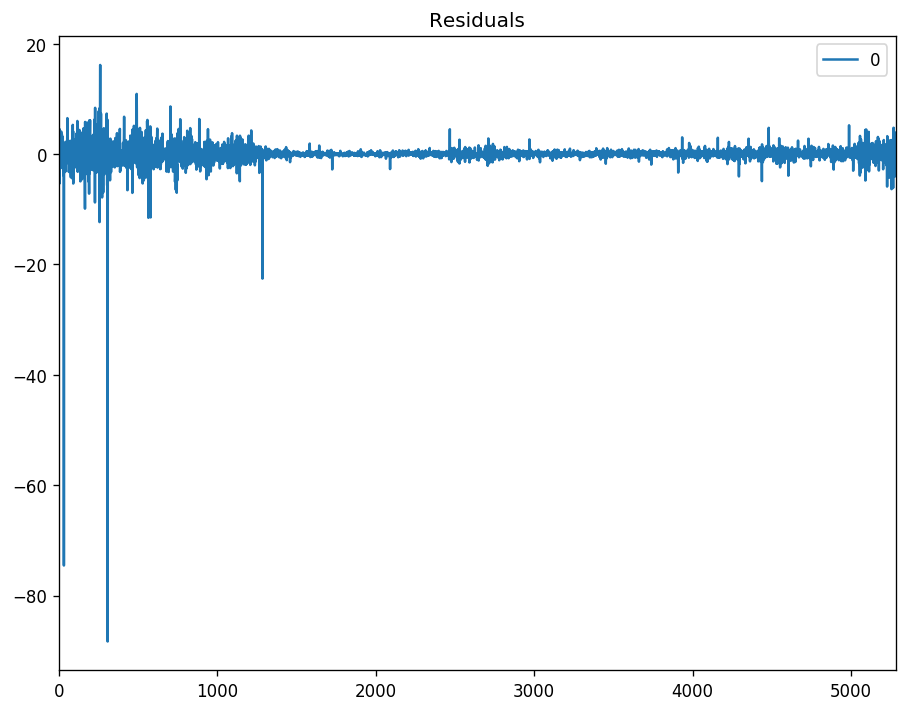

In [24]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title="Residuals")
plt.show()

### Error Check Through Actual vs Predicted Plot

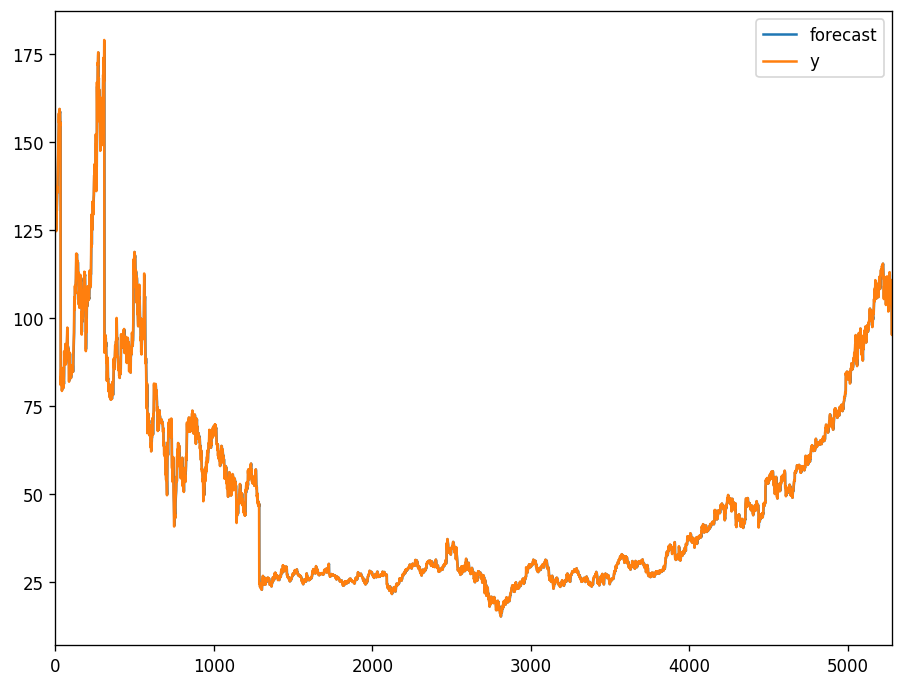

In [25]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False) # False => use in-sample lag values
plt.show()

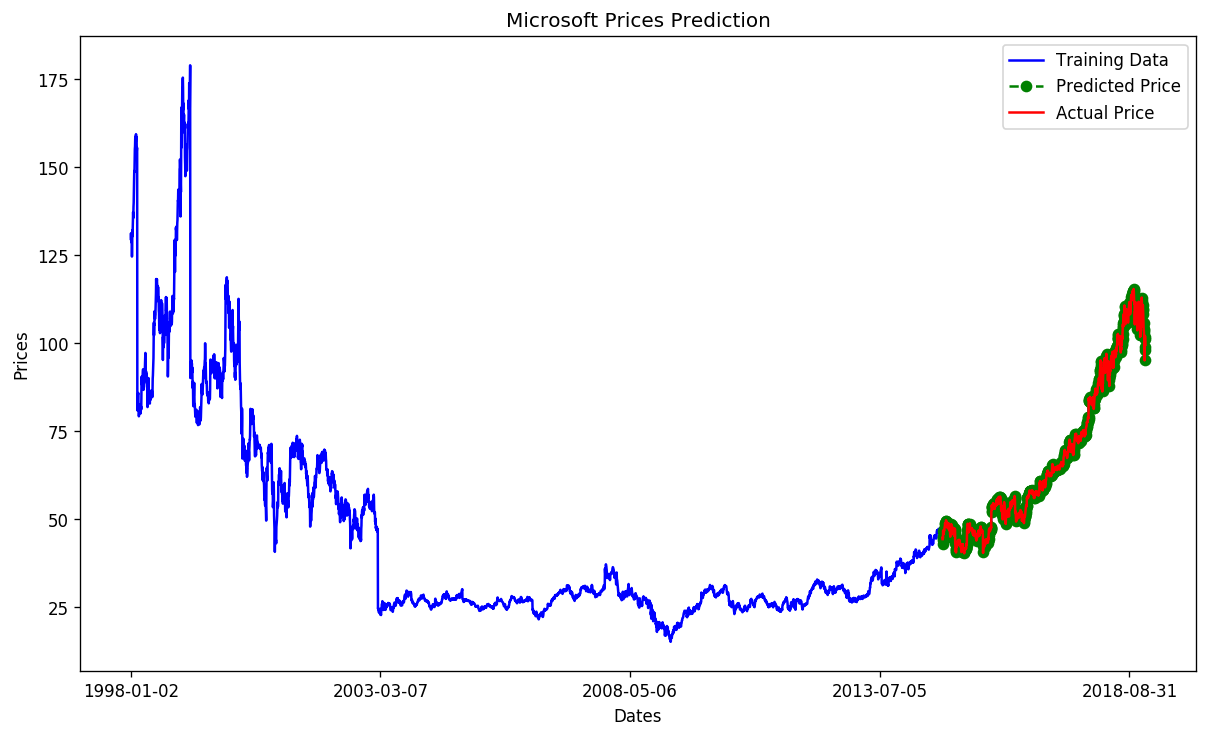

In [26]:
plt.figure(figsize=(12,7))
plt.plot(df['open'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['open'], color='red', label='Actual Price')
plt.title('Microsoft Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0, final_index, 1300), df['timestamp'][0:final_index:1300])
plt.legend()

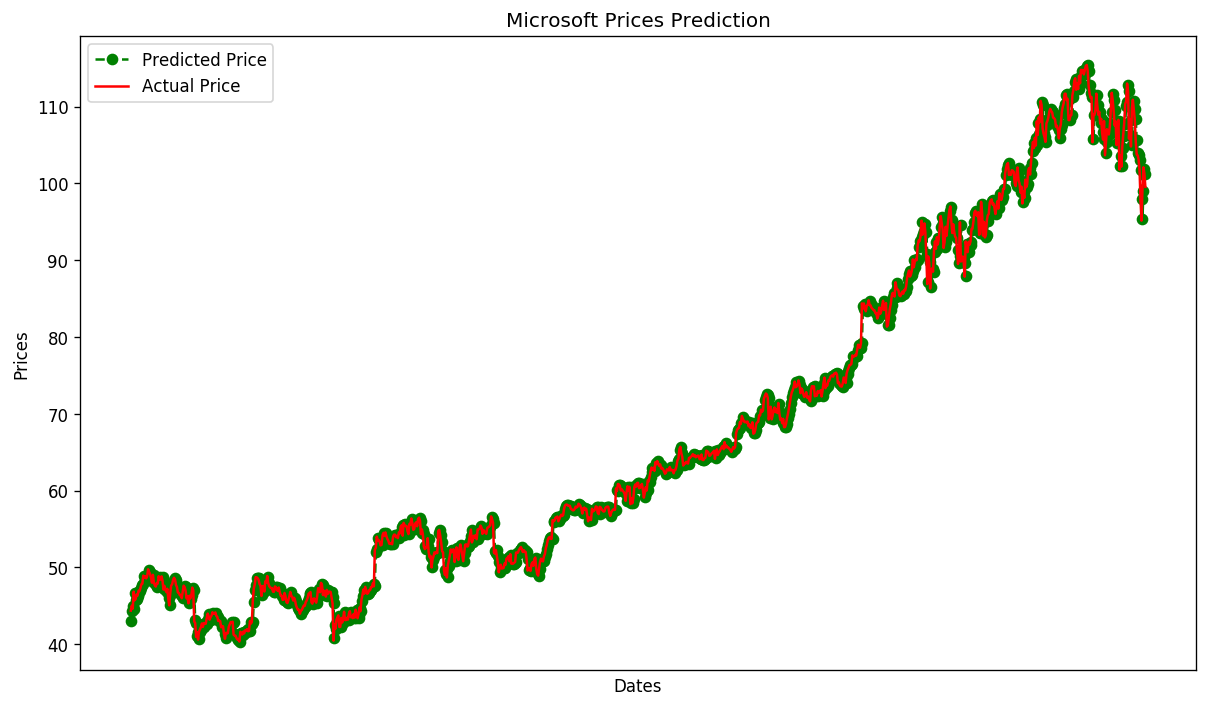

In [27]:
plt.figure(figsize=(12,7))
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['open'], color='red', label='Actual Price')
plt.title('Microsoft Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(int(0.8*len(df)), 300), df['timestamp'][int(0.8*len(df)):final_index:300])
plt.legend()

### Here, we predict the values of the test_set based on the prior predictions. That is to say, the model takes the PREDICTIONS made by it to determine the next row in the test_set, (instead of taking the ACTUAL test_set value as in the previous case).

In [58]:
est_ar_orig = test_data['open'].values

history_new = [x for x in train_ar]
print(type(history_new))
predictions_new = list()
for t in range(len(test_ar_orig)):
    # training takes place here: 
    # p = 1, d = 1, q = 1 => fails to converge
    # p = 1, d = 1, q = 0 => succeeds in 49.511s; MSE = 2023.404,SMAPE = 66.610 
    # p = 2, d = 1, q = 0 => fails to converge
    # p = 2, d = 1, q = 1 => AR coeffs fail stationarity test
    # p = 2, d = 1, q = 2 => AR coeffs fail stationarity test
    # p = 3, d = 1, q = 0 => succeeds in 117.668s; MSE = 2024.363,SMAPE = 66.646
    # p = 3, d = 1, q = 1 => AR coeffs fail stationarity test
    # p = 3, d = 1, q = 2 => something called HessianInversionWarning
    model_new = ARIMA(history_new, order=(1,1,0))
    model_fit_new = model_new.fit(disp=0)
    output_new = model_fit_new.forecast()
    yhat_new = output_new[0]
    predictions_new.append(yhat_new)
    history_new.append(yhat_new) # append the latest prediction to history
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_ar, predictions_new)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions_new)
print('Symmetric mean absolute percentage error: %.3f' % error2)

<class 'list'>
Testing Mean Squared Error: 2023.404
Symmetric mean absolute percentage error: 66.610


###### Clearly, both the error metrics are very high. This is because the ARIMA model works well for one-step out-of-sample prediction but performs poorly for multi-step out-of-sample prediction. This goes to show that stock market prediction (at least the one implemented here) does not work for long-term future scenarios.

In [60]:
# let's see what the new model is like
print(model_fit_new.summary()) 

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 5282
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -11180.575
Method:                       css-mle   S.D. of innovations              2.009
Date:                Tue, 25 Feb 2020   AIC                          22367.150
Time:                        16:47:57   BIC                          22386.866
Sample:                             1   HQIC                         22374.041
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0205      0.026     -0.789      0.430      -0.071       0.030
ar.L1.D.y     -0.0639      0.014     -4.653      0.000      -0.091      -0.037
                                    Roots           

### Error Check Through Actual vs Predicted Plot

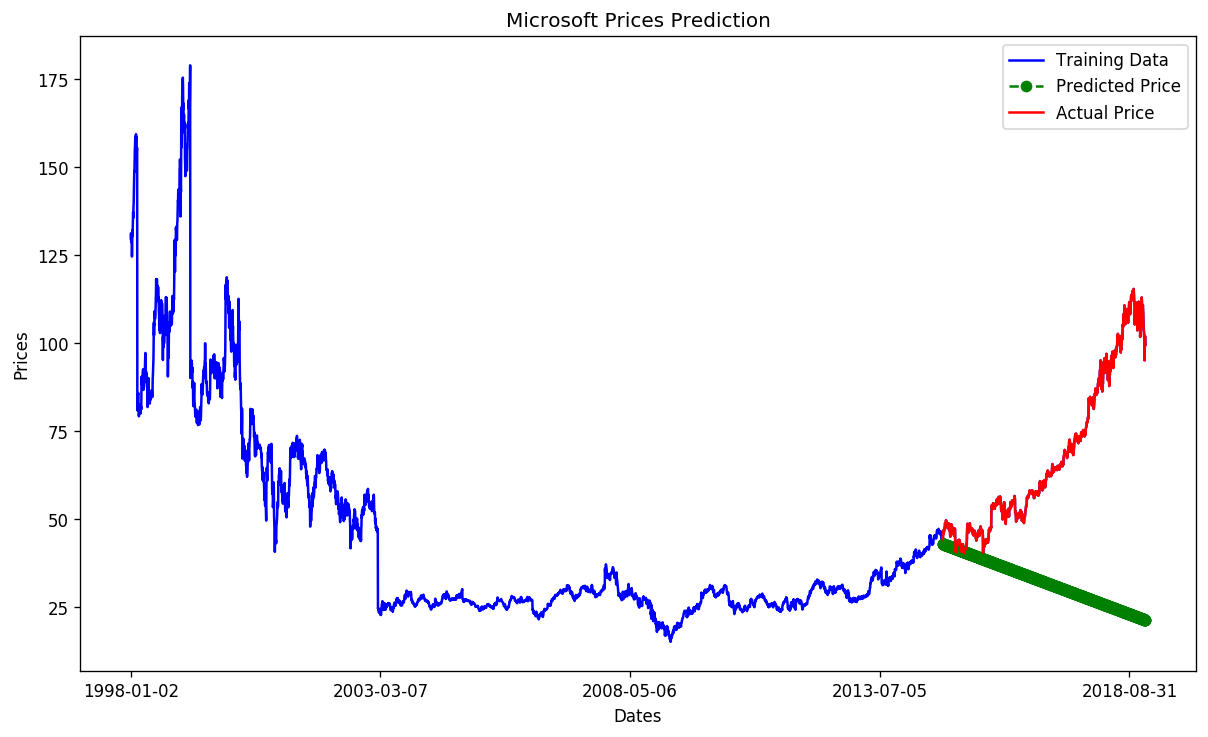

In [63]:
plt.figure(figsize=(12,7))
plt.plot(df['open'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions_new, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['open'], color='red', label='Actual Price')
plt.title('Microsoft Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0, final_index, 1300), df['timestamp'][0:final_index:1300])
plt.legend()

#### Well, well, well!